# Overview
## ML Model for Predicting RSI

### RSI
RSI is the a classic indicator used to simply measure the strength of the average direction of a price action that is normalized between 0 and 100. 

#### Formula
$$
\begin{align}
RS &= \frac{Avg_{Gain}}{Avg_{Loss}} \\
RSI &= 100 - \frac{100}{1+RS}
\end{align}
$$

### Model
The model created should be able to take an average of input, determine the average gain and loss of the period. Then average those two averages and that will generate the relative strength of the trend. But then we need to teach the model to normalize that into a boundary of 0 - 100.

### Approaches
1) Develop an model that can first predict the relative strength of the period. Then extend the model to normalized the strength into a range of 0 - 100. with the 100 bias and division of rs.

In [2]:
import tensorflow as tf;
import pandas as pd;
import numpy as np;
import talib as ta;
import math;
import matplotlib.pyplot as plt;

In [3]:
def average_gains(chunk, period):
    def gains(chunk):
        gain = 0
        for i in range(1, len(chunk)):
            if (chunk[i-1] < chunk[i]):
                gain += chunk[i] - chunk[i-1]
        return gain
    avg_total_gain = gains(chunk)/period
    return avg_total_gain
    
def average_losses(chunk, period):
    def losses(chunk):
        loss = 0
        for i in range(1, len(chunk)):
            if (chunk[i - 1] > chunk[i]):
                loss += chunk[i-1] - chunk[i]
        return loss
    
    avg_total_losses = losses(chunk)/period
    return avg_total_losses

def relative_strength_calculation(chunk, period):
    avg_total_gain = average_gains(chunk, period)
    avg_total_losses = average_losses(chunk, period)
    if avg_total_losses == 0:
        return 1
    return avg_total_gain/avg_total_losses

def rs_set_builder(data: pd.DataFrame, column: str, period: int):
    period_chunks = np.array([np.array(data[i:i+period][column]) for i in range(0, data.shape[0] - period)])
    rs = np.array([relative_strength_calculation(period_chunks[i], period) for i in range(len(period_chunks))])
    
    x_train, x_test = period_chunks[0:math.ceil(len(period_chunks)/2)], period_chunks[math.ceil(len(period_chunks)/2):]
    y_train, y_test = rs[0:math.ceil(len(rs)/2)], rs[math.ceil(len(rs)/2):]
    
    return (
        (x_train, x_test),
        (y_train, y_test)
    )

In [4]:
spx_data = pd.read_csv(
    './data/SPX_2019_1min.csv',
    header=None,
    names=["date", "open", "high", "low", "close"],
    parse_dates=["date"],
    index_col=['date']
)

In [5]:
(
    (spx_rs_x_train, spx_rs_x_test),
    (spx_rs_y_train, spx_rs_y_test)
) = rs_set_builder(spx_data, "close", 7)

In [6]:
rs_model = tf.keras.models.Sequential()
rs_model.add(tf.keras.layers.Input(shape=(spx_rs_x_train.shape[1],), dtype="float64"))
rs_model.add(tf.keras.layers.Dense(256, activation="relu"))
rs_model.add(tf.keras.layers.Dense(1))

rs_model.compile(optimizer='adam', loss="mean_squared_error")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-22 21:04:58.184198: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-22 21:04:58.184937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
rs_model.fit(spx_rs_x_train, spx_rs_y_train, epochs=25, verbose=1, batch_size=1024)

Epoch 1/25


2023-02-22 21:04:58.359506: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 9/48 [====>.........................] - ETA: 0s - loss: 154203.4062 

2023-02-22 21:04:58.715895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 10ms/step - loss: 39418.2305
Epoch 2/25
48/48 [==============================] - 0s 10ms/step - loss: 625.6086
Epoch 3/25
48/48 [==============================] - 1s 11ms/step - loss: 434.7695
Epoch 4/25
48/48 [==============================] - 1s 11ms/step - loss: 432.2271
Epoch 5/25
48/48 [==============================] - 1s 11ms/step - loss: 431.9943
Epoch 6/25
48/48 [==============================] - 0s 8ms/step - loss: 432.2981
Epoch 7/25
48/48 [==============================] - 0s 6ms/step - loss: 433.4307
Epoch 8/25
48/48 [==============================] - 0s 6ms/step - loss: 432.7733
Epoch 9/25
48/48 [==============================] - 0s 9ms/step - loss: 431.7684
Epoch 10/25
48/48 [==============================] - 0s 5ms/step - loss: 433.1232
Epoch 11/25
48/48 [==============================] - 0s 5ms/step - loss: 432.8626
Epoch 12/25
48/48 [==============================] - 0s 5ms/step - loss: 433.3812
Epoch 13/25
48/48 [==========

In [8]:
rs_model.evaluate(spx_rs_x_test, spx_rs_y_test, batch_size=1024)

 6/48 [==>...........................] - ETA: 0s - loss: 287.7989

2023-02-22 21:05:07.610334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 0s 7ms/step - loss: 401.3322


401.3322448730469

2023-02-22 21:05:08.085985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


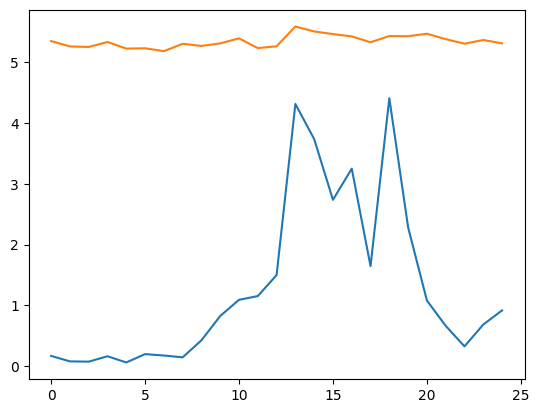

In [9]:
plt.plot(spx_rs_y_test[:25])
plt.plot(rs_model.predict(spx_rs_x_test[:25], verbose=0))

# Initial Thoughts on Generating Simple RS model
Right now it does seem like the model is not able to learn what relative strength is given the chunk of close prices. I believe this might be due to the neurons not able to regressively extract what is consider a gain avg and a loss avg... Thus they can not "learn" to divide it by each other. I might first need to rain a two models to first extract the avg gain and avg loss... Then pass those into a model for it to learn how then generate the rs average. Going to try and see if I can train it to recognize gains and then average those.

In [10]:
spx_avg_gains = np.array([average_gains(spx_data[i:i+7]['close'], 7) for i in range(len(spx_data)-7)])
spx_avg_gains_y_train, spx_avg_gains_y_test = spx_avg_gains[0:math.ceil(len(spx_avg_gains)/2)], spx_avg_gains[math.ceil(len(spx_avg_gains)/2):]

In [11]:
avg_gain_model = tf.keras.models.Sequential()
avg_gain_model.add(tf.keras.layers.Input(shape=spx_rs_x_train.shape[1], dtype="float64"))
avg_gain_model.add(tf.keras.layers.LayerNormalization())
avg_gain_model.add(tf.keras.layers.Dense(2056, activation="relu"))
avg_gain_model.add(tf.keras.layers.LayerNormalization())
avg_gain_model.add(tf.keras.layers.Dense(1))

avg_gain_model.compile(optimizer='adam', loss="mean_squared_error")

In [12]:
avg_gain_model.fit(spx_rs_x_train, spx_avg_gains_y_train, epochs=3, batch_size=1024)

Epoch 1/3
 1/48 [..............................] - ETA: 17s - loss: 476.4468

2023-02-22 21:05:13.614461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 17ms/step - loss: 52.1523
Epoch 2/3
48/48 [==============================] - 1s 14ms/step - loss: 0.1810
Epoch 3/3
48/48 [==============================] - 1s 13ms/step - loss: 0.0755


In [13]:
avg_gain_model.evaluate(spx_rs_x_test, spx_avg_gains_y_test, batch_size=1024)

15/48 [========>.....................] - ETA: 0s - loss: 0.1027

2023-02-22 21:05:16.777000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 11ms/step - loss: 0.0806


0.0806363895535469

2023-02-22 21:05:18.540979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-22 21:05:18.650410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[0.2904384]]
[0.08571429]


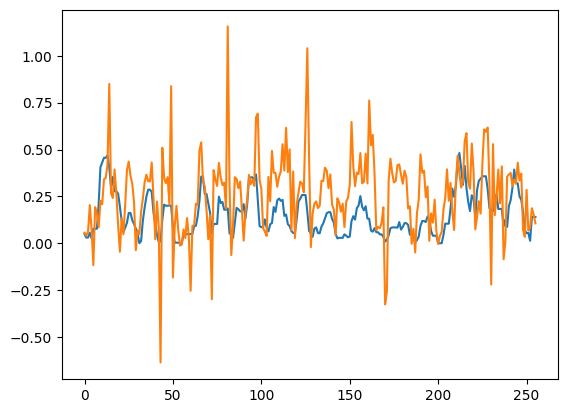

In [14]:
plt.plot(spx_avg_gains_y_test[:256])
plt.plot(avg_gain_model.predict(spx_rs_x_test[:256], verbose=0))
print(avg_gain_model.predict(spx_rs_x_test[100:101], verbose=0))
print(spx_avg_gains_y_test[100:101])

# Thoughts on Generating Average Gains
The model is having trouble fitting the average gain... I would have thought that it could better average a single a group of prices. But I think the model is having trouble isolating the positive gains. Maybe we need a model that will attempt to learn what are the gainers and the losses in a model. Although if we isolated those features manually, via feature engineering it might prove to me easier. I would like the model to purely discover and learn how to create RSI from scratch.

## Strategy
Make the model first classify if a tick was a gain or a loss. Then use that classification context to then determine the gain and loss of a period. That then could be used to get a avg gain and loss of a period. Then use those to produce a RS.

In [83]:
def classify_data_for_gain_or_loss(data: pd.DataFrame, column: str, period: int):
    
    # Returns an array of length period - 1, and return an array of 1 if gain and 0 if loss
    def loss_or_gain(chunk, period):
        gain_or_loss = [];
        for i in range(1, period):
            if chunk[i-1] < chunk[i]:
                gain_or_loss.append(1)
            else:
                gain_or_loss.append(0)
        return gain_or_loss
    
    period_chunks = np.array([np.array(data[i:i+period][column]) for i in range(0, data.shape[0] - period)])
    classify_gain_or_loss = np.array([loss_or_gain(period_chunks[i], period) for i in range(len(period_chunks))])
    
    y_train, y_test = classify_gain_or_loss[0:math.ceil(len(classify_gain_or_loss)/2)], classify_gain_or_loss[math.ceil(len(classify_gain_or_loss)/2):]
    
    return (y_train, y_test)

In [84]:
classify_gain_or_loss_y_train, classify_gain_or_loss_y_test = classify_data_for_gain_or_loss(spx_data, "close", 7)

In [145]:
classify_gain_or_loss_model = tf.keras.models.Sequential()
classify_gain_or_loss_model.add(tf.keras.layers.Input(shape=(spx_rs_x_train.shape[1],), dtype="float64"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(128, activation="relu"))
classify_gain_or_loss_model.add(tf.keras.layers.Dense(6, activation="linear"))
classify_gain_or_loss_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [146]:
classify_gain_or_loss_model.fit(spx_rs_x_train, classify_gain_or_loss_y_train, epochs=25, batch_size=1024)

Epoch 1/25


2023-02-22 22:02:58.170115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/2y/zngzgkjn5j7ghwmmj_f0ytdh0000gn/T/ipykernel_4480/1929027291.py", line 1, in <module>
      classify_gain_or_loss_model.fit(spx_rs_x_train, classify_gain_or_loss_y_train, epochs=25, batch_size=1024)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 985, in launch_instance
      app.start()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/2y/zngzgkjn5j7ghwmmj_f0ytdh0000gn/T/ipykernel_4480/1929027291.py", line 1, in <module>
      classify_gain_or_loss_model.fit(spx_rs_x_train, classify_gain_or_loss_y_train, epochs=25, batch_size=1024)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/losses.py", line 1860, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/nateageek/Library/Python/3.9/lib/python/site-packages/keras/backend.py", line 5238, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [1024,6] and labels shape [6144]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
	 [[Equal/_19]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [1024,6] and labels shape [6144]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_164794]

In [129]:
classify_gain_or_loss_model.evaluate(spx_rs_x_test, classify_gain_or_loss_y_test, batch_size=1024)

 3/48 [>.............................] - ETA: 1s - loss: 130.7195 - accuracy: 0.2083

2023-02-22 21:44:40.337126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 1s 18ms/step - loss: 130.6936 - accuracy: 0.2166


[130.69363403320312, 0.2166127860546112]

In [132]:
predicted_gain = classify_gain_or_loss_model.predict(spx_rs_x_test, batch_size=1024)
print(classify_gain_or_loss_y_test[3])
print(predicted_gain[3])
print(tf.nn.sigmoid(predicted_gain[3]))

48/48 [==============================] - 0s 8ms/step
[1 0 0 0 0 1]
[-94.50432   36.68466  -19.294262  36.108257  17.017551  -5.378902]
tf.Tensor(
[0.0000000e+00 1.0000000e+00 4.1745412e-09 1.0000000e+00 1.0000000e+00
 4.5917034e-03], shape=(6,), dtype=float32)


So I am having a bit of trouble making the model predict what are 

Chatting with a friend, I might want to take a simpler approach to the development of classifying gains. Going to start by extracting and doing more feature engineering on the data. Going to create a difference calculation... Perhaps manually by subtracting or by dense layer. As I believe that the layer should be able to normalize a pattern to subtract related neighbors in the input.

In [21]:
diff_spx_train = np.diff(spx_rs_x_train, axis=1)
diff_spx_test = np.diff(spx_rs_x_test, axis=1)

In [22]:
# Difference Calculator Model

diff_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(diff_spx_train.shape[1], )),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(6)
])
diff_model.compile(optimizer="adam", loss=tf.keras., metrics=['accuracy'])


SyntaxError: invalid syntax (2319616288.py, line 8)

In [23]:
diff_model.fit(diff_spx_train, classify_gain_or_loss_y_train, epochs=100, batch_size=1024)

NameError: name 'diff_model' is not defined

In [24]:
diff_model.evaluate(diff_spx_test, classify_gain_or_loss_y_test, batch_size=1024)

NameError: name 'diff_model' is not defined

In [25]:
predicted_diffs = diff_model.predict(diff_spx_test, batch_size=1024)
print(classify_gain_or_loss_y_train[0])
print(predicted_diffs[0])

NameError: name 'diff_model' is not defined